In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [11]:
# 处理数据，uv处理成风向和风速
data = pd.read_csv('./used_multi.csv')
wnd_dir = []
wnd_spd = []
for i in range(len(data)):
    u = data['u'][i]
    v = data['v'][i]
    fx = 999.9
    if (u>0) & (v>0):
        fx = fx = 270 - math.atan(v / u) * 180 / math.pi
    elif (u < 0) & (v > 0):
        fx = 90 - math.atan(v / u) * 180 / math.pi
    elif (u < 0) & (v < 0):
        fx = 90 - math.atan(v / u) * 180 / math.pi
    elif (u > 0) & (v < 0):
        fx = 270 - math.atan(v / u) * 180 / math.pi
    elif (u == 0) & (v > 0):
        fx = 180
    elif (u == 0) & (v < 0):
        fx = 0
    elif (u > 0) & (v == 0):
        fx = 270
    elif (u < 0) & (v == 0):
        fx = 90
    elif (u == 0) & (v == 0):
        fx = 999.9
    else:
        fx = 999.9
    wnd_dir.append(fx)

    # 风速是uv分量的平方和
    fs = math.sqrt(math.pow(u,2) + math.pow(v,2))
    wnd_spd.append(fs)
# 增加到文件中
add_file_path = './used_multi.csv'
data['wnd_dir'] = wnd_dir
data['wnd_spd'] = wnd_spd
data.to_csv(add_file_path,header=True,index=None)

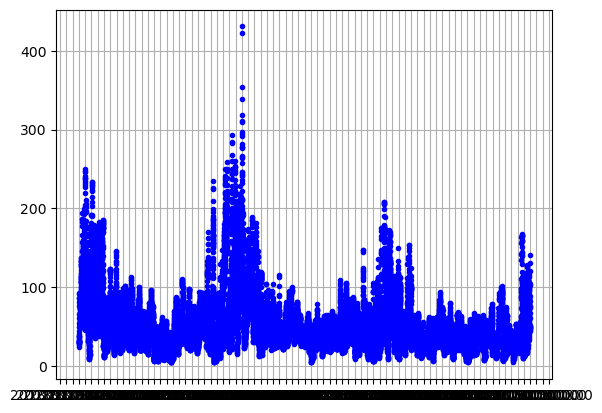

,date,pm25,u,v,temp,rh,psfc,wnd_dir,wnd_spd
0,20130101 00:00:00,30.37,3.59,5.15,275.43,37.25,95350.46,214.879866,6.277786
1,20130101 01:00:00,30.46,3.62,4.97,275.27,35.13,95340.69,216.068480,6.148601
2,20130101 02:00:00,30.36,3.66,4.83,275.14,33.51,95358.41,217.153538,6.060074
3,20130101 03:00:00,29.61,3.60,4.80,275.01,32.11,95381.27,216.869898,6.000000
4,20130101 04:00:00,29.37,3.30,4.61,274.99,29.82,95395.44,215.596419,5.669400


In [2]:
from matplotlib.dates import AutoDateLocator, DateFormatter

# 多变量时间序列的信息展示
data = pd.read_csv('./used_multi.csv')
plt.plot_date(data.date, data.pm25, fmt='b.')

ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=1314)) #设置展示时间间隔

plt.grid()

plt.show()
                    
data.head()

In [41]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

data = pd.read_csv('./multi_weighted24.csv')
value = data['pm25']

# 这部分是前端data view展示的信息
print('the length of data:', len(value))
print('the type of data:', type(value[1]))
print('any null?',np.isnan(value).any())
print('the average of data:', value.mean())
print('the variance of data:',value.var())
print('the skewness of data:',value.skew()) # 偏度<0称为负偏，>0称为正偏，=0说明相对均匀的分布在平均值的两侧，偏度绝对值过大的话，说明长尾的一侧出现极端值的可能性比较高
print('the kuriosis of data:',value.kurt()) # 峰度用来描述数据分布陡峭还是平滑，方差相同情况下，峰度越大，存在极端值的可能性更大

# sm.tsa.acf(value)
# fig = tsaplots.plot_acf(value,lags=600)
# plt.axvline(120,color='red')
# plt.show()

the length of data: 26280
the type of data: <class 'numpy.float64'>
any null? False
the average of data: 51.24520322535009
the variance of data: 967.2104043376645
the skewness of data: 2.0684096004436796
the kuriosis of data: 5.584287353298606


In [42]:
from scipy.fftpack import fft, fftfreq
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

# ADF test:
fuller_result = adfuller(data['pm25'],autolag='AIC')
print(f'ADF Statistic:{fuller_result[0]}')
print(f'p-value:{fuller_result[1]}')
for key, value in fuller_result[4].items():
    print('Critial Values:')
    print(f'{key},{value}')

# FFT test
fft_series = fft(data['pm25'].values)
power = np.abs(fft_series)
sample_freq = fftfreq(fft_series.size)

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
powers = power[pos_mask]

# top_k_seasons = 3
# # top K=3 index
# top_k_idxs = np.argpartition(powers, -top_k_seasons)[-top_k_seasons:]
# top_k_power = powers[top_k_idxs]
# fft_periods = (1 / freqs[top_k_idxs]).astype(int)

# print(f"top_k_power: {top_k_power}")
# print(f"fft_periods: {fft_periods}")

# Expected time period
# for lag in fft_periods:
#     # lag = fft_periods[np.abs(fft_periods - time_lag).argmin()]
#     acf_score = acf(data["pm25"].values, nlags=lag)[-1]
#     print(f"lag: {lag} fft acf: {acf_score}")

# 测试预设的值130，260，390
# 0225测试，对应step的自相关性
expected_lags = [3,6,12,24]
for lag in expected_lags:
    acf_score = acf(data['pm25'].values, nlags=lag, fft=False)[-1]
    print(f"lag: {lag} expected acf: {acf_score}")

ADF Statistic:-9.27899518550724
p-value:1.2660609733450488e-15
Critial Values:
1%,-3.43059933054021
Critial Values:
5%,-2.861650196777599
Critial Values:
10%,-2.566828654483077
lag: 3 expected acf: 0.9932167234442464
lag: 6 expected acf: 0.9762166680786506
lag: 12 expected acf: 0.9266959622151875
lag: 24 expected acf: 0.8122836398356925


<AxesSubplot:xlabel='wnd_dir', ylabel='wnd_spd'>

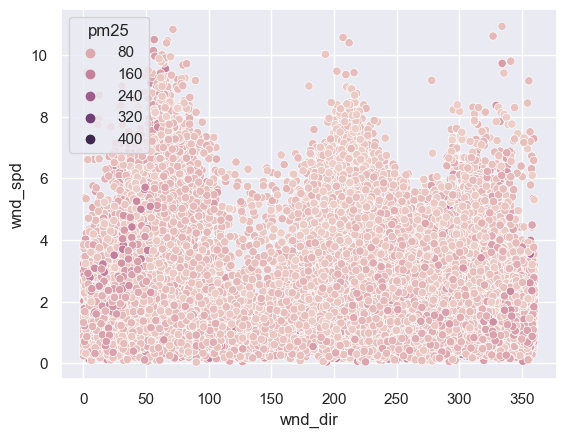

In [15]:
import seaborn as sns
sns.set()
sns.scatterplot(x = data['wnd_dir'], y = data['wnd_spd'], hue = data['pm25'], data = data['pm25'])


In [21]:
# 多变量时间序列数据处理
# 除了风向，其他的值都需要跟着处理
raw_data = pd.read_csv('./used_multi.csv')

raw_date = raw_data['date']
raw_pm25 = raw_data['pm25']
raw_temp = raw_data['temp']
raw_rh = raw_data['rh']
raw_psfc = raw_data['psfc']
raw_dir = raw_data['wnd_dir']
raw_spd = raw_data['wnd_spd']

tmp = 3
rolling_name = './multi_rolling3.csv'
weighted_name = './multi_weighted3.csv'

# 处理五个变量
rolling_pm25 = raw_pm25.rolling(window=tmp).mean()
rolling_temp = raw_temp.rolling(window=tmp).mean()
rolling_rh = raw_rh.rolling(window=tmp).mean()
rolling_psfc = raw_psfc.rolling(window=tmp).mean()
rolling_spd = raw_spd.rolling(window=tmp).mean()

weighted_pm25 = raw_pm25.ewm(span=tmp).mean()
weighted_temp = raw_temp.ewm(span=tmp).mean()
weighted_rh = raw_rh.ewm(span=tmp).mean()
weighted_psfc = raw_psfc.ewm(span=tmp).mean()
weighted_spd = raw_spd.ewm(span=tmp).mean()

rolling_info = pd.DataFrame({'date':raw_date,'pm25':rolling_pm25,'temp':rolling_temp,'rh':rolling_rh,'psfc':rolling_psfc,'wnd_dir':raw_dir,'wnd_spd':rolling_spd})
rolling_info.to_csv(rolling_name,encoding="UTF-8")
weighted_info = pd.DataFrame({'date':raw_date,'pm25':weighted_pm25,'temp':weighted_temp,'rh':weighted_rh,'psfc':weighted_psfc,'wnd_dir':raw_dir,'wnd_spd':weighted_spd})
weighted_info.to_csv(weighted_name,encoding="UTF-8")